In [157]:
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import scipy.integrate as integrate
import torch
import time

In [59]:
time = 300
delta_t = 0.01

b = 65
a = -0.8
tau_w = 88
cm = 104
g_L = 4.3
E_L = -65 #-70
V_T = -52
V_thr = 0
V_reset = -53
slope_f = 0.8
I = 150
# E_ex = 0
# E_inh = -70
# tau_ex = 6
# delta_g_ex = 12.5 #1.25 #0.01
# g_ex = 0
# delta_g_inh = 30 #3 #0.01
# g_inh = 0
# tau_inh = 3



In [60]:
n_ains = 1
vs_to_plot = []
ws = []
spike_num = 0
ain_w = np.zeros((n_ains,1))
ain_voltage_vec = np.zeros((n_ains,1))
ain_voltage_vec[:,:] += E_L
n_timesteps = len(np.arange(0,time,delta_t))
ain_voltage_record = np.zeros((n_record,n_timesteps))

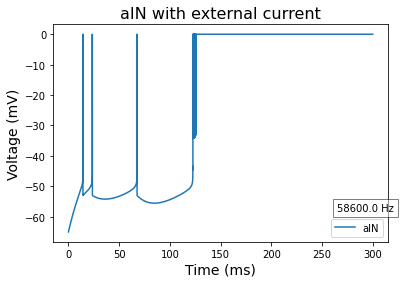

In [61]:
for idx,t in enumerate(np.arange(0,time,delta_t)):
    for ain in range(n_ains):
        if ain_voltage_vec[ain,-1] >= V_thr:
            ain_voltage_vec[ain,-1] = V_reset
            spike_num += 1
    if ain_voltage_vec[0,-1] < -45 and ain_voltage_vec[0,-1] > -70:       
        vs_to_plot.append(ain_voltage_vec[0,-1])
        ws.append(ain_w[0,-1])
    ain_voltage_vec[:,-1] += delta_t*((-g_L*(ain_voltage_vec[:,-1] - E_L) + g_L * slope_f * np.exp((ain_voltage_vec[:,-1] - V_T)/slope_f) \
                                         + I - ain_w[:,-1]) / cm)
    ain_w += delta_t*((a * (ain_voltage_vec - E_L) - ain_w) / tau_w)
    for ain in range(n_ains):
        if ain_voltage_vec[ain,-1] >= V_thr:
            ain_voltage_vec[ain,-1] = V_thr
            ain_spike_times[ain].append(t)
            ain_w[ain,-1] += b
    ain_voltage_record[:,idx] += ain_voltage_vec[0,:].squeeze()
    
x = np.arange(0,time,delta_t) 

for i in range(1):
    plt.plot(x,ain_voltage_record[i,:],label='aIN')
plt.title('aIN with external current',fontsize='16')
plt.xlabel('Time (ms)',fontsize='14')
plt.ylabel('Voltage (mV)',fontsize='14')
ain_w = np.zeros((n_ains,1))
fr = spike_num / (time/1000)
plt.text(265, -58, '%s' % float('%.3g' % fr) +" Hz", bbox=dict(facecolor='white', alpha=0.5))
plt.legend()
# plt.savefig('Figures/ain10pAcm20' + '%s' % float('%.3g' % fr), format='pdf')

In [483]:
class Innerloop_NeuronSim(): 
    
    def __init__(self, inner_loop_params):
        self.dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.ns = inner_loop_params['n_samples_per_dataset']
        self.nd = inner_loop_params['n_datasets']
        self.nr = inner_loop_params['n_rules']
        self.time = inner_loop_params['time']
        self.delta_t = inner_loop_params['delta_t']
        self.ne = int(inner_loop_params['time'] / inner_loop_params['delta_t'])
        self.V_thr = inner_loop_params['V_thr']
        self.spike_times = []
        
#         self.V = torch.zeros((self.nr, self.nd, self.ns), dtype=torch.double, device=self.dev)
#         self.W = torch.zeros((self.nr, self.nd, self.ns), dtype=torch.double, device=self.dev)
        aux = 70*torch.ones((self.nd, self.ns), dtype=torch.double, device=self.dev) \
        + torch.randn([self.nd, self.ns], dtype=torch.double, device=self.dev)
        self.V = aux.repeat(self.nr,1,1)
        self.W = torch.zeros((self.nr, self.nd, self.ns), dtype=torch.double, device=self.dev)
        stats = torch.zeros((self.nr, self.nd, self.ns, 7), dtype=torch.double, device=self.dev)
        stats[:,:,:,1:] = -1
        self.stats = stats
        self.current_time = 0
        self.volt_dict = {}
        for r in range(self.nr):
            for d in range(self.nd):
                for s in range(self.ns):
                    self.volt_dict[r,d,s] = []
        
        #blow up handling
        self.blow_up =  [self.ne for i in range(self.nr)] #epoch at which the nets blew up (n_ep = no blow up) 
        self.not_blown = [i for i in range(self.nr)] #dimensions which did not blow up yet
        self.a_blow = inner_loop_params['a_blow']
        self.b_blow = inner_loop_params['b_blow']
        
        #input datasets
        self.exp_stats = inner_loop_params['exp_stats']
        self.exp_volt_dict = inner_loop_params['exp_volt_dict']
    
    
    def reset(self):
        aux = 70*torch.ones((self.nd, self.ns), dtype=torch.double, device=self.dev) \
        + torch.randn([self.nd, self.ns], dtype=torch.double, device=self.dev)
        self.V = aux.repeat(self.nr,1,1)
        self.W = torch.zeros((self.nr, self.nd, self.ns), dtype=torch.double, device=self.dev)
        stats = torch.zeros((self.nr, self.nd, self.ns, 7), dtype=torch.double, device=self.dev)
        stats[:,:,:,1:] = -1
        self.stats = stats

        #blow up handling
        self.blow_up = [self.ne for i in range(self.nr)] #epoch at which the nets blew up (n_ep = no blow up) 
        self.not_blown = [i for i in range(self.nr)] #dimensions which did not blow up yet
    
        
        
    def forward(self,A):
        for rule in range(self.nr):
            self.V[rule][self.V[rule]>=self.V_thr] = A[rule][8]
        print(A.shape())
        self.V += self.delta_t*((-1*A_exp[:,:,:,1]*(self.V-A_exp[:,:,:,2]) + \
                A_exp[:,:,:,1] * A_exp[:,:,:,4] \
                * torch.exp((self.V - A_exp[:,:,:,3])/A_exp[:,:,:,4]) \
                + A_exp[:,:,:,9] - self.W) / A_exp[:,:,:,0])
        self.W += self.delta_t*((A_exp[:,:,:,5] * (self.V - A_exp[:,:,:,2]) - self.W) / A_exp[:,:,:,6])
        spike = self.V.numpy() >= self.V_thr
        indices = spike.nonzero()
        # if between spike 1 and 2, keep track of voltage at every 1ms and find minimum voltage
        if self.current_time % 1 == 0:
            for r in range(self.nr):
                for d in range(self.nd):
                    for s in range(self.ns):
                        if self.stats[r,d,s,3] == -1:
                            self.volt_dict[r,d,s].append(self.V[r,d,s])
                        if self.stats[r,d,s,4] == -1 and not self.stats[r,d,s,3] == -1:
                            if self.stats[r,d,s,6] == -1:
                                self.stats[r,d,s,6] = self.V[r,d,s]
                            else:
                                self.stats[r,d,s,6] = torch.min(self.stats[r,d,s,6], self.V[r,d,s])
        print(self.stats[self.V>self.V_thr].size())
        # update number of spikes 
        self.stats[(self.V>self.V_thr),0] += 1
        # update spike times and calculate latency to first spike (3) and between 1st and 2nd (4)
        if len(self.V[indices]) != 0:
            for idx in indices:
                index = (idx[0],idx[1],idx[2])
                if self.stats[index,1].isnan():
                    self.stats[index,3] = self.current_time
                elif self.stats[index,4].isnan() and not self.stats[index,3].isnan():
                    self.stats[index,2] = self.current_time
                    self.stats[index,4] = self.current_time - self.stats[index,3]
                else:
                    self.stats[index,1] = self.stats[index,2]
                    self.stats[index,2] = self.current_time
        self.V[self.V>=self.V_thr] = self.V_thr
        for r in range(self.nr):
            self.W[r,:,:,:][self.V[r,:,:,:]>=self.V_thr]+= A[r,7]
        self.current_time += self.delta_t
        # if at last timestep, calculate time between last and 2nd last spikes
        if self.current_time == self.time:
            self.stats[:,:,:,5] = self.stats[:,:,:,2] - self.stats[:,:,:,1]
    
    
    def train(self, A): 
        A = torch.tensor(A, dtype=torch.double, device=self.dev)
        for epoch_num in range(self.ne):
            self.forward(A)
            
            #handle blow-ups
            if not torch.equal(self.V,self.V): #nan != nan: there is a nan somewhere (ie blow up). Fast to compute
                dim_to_remove = []
                for r_num in self.not_blown:
                    if not torch.equal(self.V[r_num, :, :], self.V[r_num, :, :]):
                        self.blow_up[r_num] = epoch_num
                        dim_to_remove.append(r_num)
                self.not_blown = [x for x in self.not_blown if x not in dim_to_remove]
                
        for r_num in self.not_blown: #check for unrealistic values e.g. V > 100mV or < -100mV or number of spikes > 500
            dim_to_remove = []
            if torch.max(self.V[r_num]).item() > 100 or torch.min(self.V[r_num]).item() < -100 \
            or torch.max(self.stats[r_num,:,:,0]) > 500:
                self.blow_up[r_num] = self.ne - 1
                dim_to_remove.append(r_num)
        self.not_blown = [x for x in self.not_blown if x not in dim_to_remove]  
        
    
    def score(self, A):
        self.reset()
        self.train(A)
        self.has_blown_up = False
        err_mean = [0]*self.nr
        for r_num in range(self.nr):
            if self.blow_up[r_num] < self.ne: # blow up on this perturbation of A
                self.has_blown_up = True
                err_mean[r_num] = self.a_blow*(self.ne - self.blow_up[r_num])/(self.ne) + self.b_blow
            else:
                sum_stat1 = 0
                sum_stat2 = 0
                sum_stat3 = 0
                sum_stat4 = 0
                sum_stat5 = 0
                sum_stat6 = 0
                for d_num in range(self.nd):
                    sum_stat1 +=  (np.mean(exp_stats[0][d_num]) - self.stats[r_num, d_num, 0]) / np.var(exp_stats[0])
                    sum_stat2 += (np.mean(exp_stats[1][d_num]) - self.stats[r_num, d_num, 3]) / np.var(exp_stats[1])
                    sum_stat3 += (np.mean(exp_stats[2][d_num]) - self.stats[r_num, d_num, 4]) / np.var(exp_stats[2])
                    sum_stat4 += (np.mean(exp_stats[3][d_num]) - self.stats[r_num, d_num, 5]) / np.var(exp_stats[3])
                    sum_stat5 += (np.mean(exp_stats[4][d_num]) - self.stats[r_num, d_num, 6]) / np.var(exp_stats[4])
                chisq1 = (1/3)*sum_stat1
                chisq2 = (1/3)*sum_stat2
                chisq3 = (1/3)*sum_stat3
                chisq4 = (1/3)*sum_stat4
                chisq5 = (1/3)*sum_stat5
                for d_num in range(self.nd):
                    for sample in range(self.ns):
                        max_len = np.min(len(self.exp_volt_dict[d_num,sample]), len(self.volt_dict[r_num,d_num,sample]))
                        diff = self.exp_volt_dict[d_num,sample][:max_len] - self.volt_dict[r_num,d_num,sample][:max_len]
                        diff_sq = [val**2 for val in diff]
                        sum_stat6 += integrate.quad(lambda x: diff_sq, 0, np.mean(exp_stats[0][d_num]) \
                        -2*np.std(exp_stats[0][d_num]))
                chisq6 = (1/3)*sum_stat6
                total_cost = chisq1 + chisq2 + chisq3 + chisq4 + chisq5 + chisq6
                err_mean[r_num] += total_cost
        return(err_mean)
    
    
    
    def check_blow_up(self):
        return(self.has_blown_up)
    
    
    
    def print(self):
        print(""); print("Parameters for InnerLoop_NeuronSim:")
        print("ni=" + str(self.ni) + " time=" + str(self.time) + " delta_t=" + str(self.delta_t) \
              + " V_thr=" + str(self.V_thr) + " ns=" + str(self.ns) + " ne=" + str(self.ne) \
            + " nd=" + str(self.nd) + " nr=" + str(self.nr) + \
            " dev=" + str(self.dev) + " a_blow=" + str(self.a_blow) + " b_blow=" + str(self.b_blow)); print("")
              
            
            
    def info(self):
        print(""); print("Information on InnerLoop_NeuronSim:")
        print("Simulate neurons for 3 different input curents (nd=3)")
        print("Parallelized on ns, nd and nr (number of different parameter combiations run at the same time)")
        print("size(V) = [nr, nd, ns], size(W) = [nr, nd, ns]")
        print("Convention: A = [nr, lr] lr = 10")
        print("Parameters initialised at values converged on for a neuron type in the Naud et al., 2008 paper");print("")  

In [484]:
class OuterLoop_CMA_ES():
       
    def __init__(self, outer_loop_params, inner_loop_params):
        
        # L1 regularization on parameter combinations
        self.reg = outer_loop_params["reg"]
        
        # optimizer parameters
        self.lr = len(outer_loop_params["A"])
        self.current_meta_it = 0
        if outer_loop_params["lambd"] == "auto":
            self.lambd = int(4 + np.floor(3*np.log(len(outer_loop_params["A"])))) #number of search points in a generation #population size
            print("generation size lambda = " + str(self.lambd))
        else:
            self.lambd = outer_loop_params["lambd"]
        inner_loop_params["n_rules"] = self.lambd + 1 #+1 cuz we will test self.m for plotting purpose in addition
        self.mu = int(np.floor(self.lambd/2)) #number of non negative recombination weights
        wi_aux = np.array([np.log((self.lambd + 1)/2) - np.log(i+1) for i in range(self.lambd)])
        self.mu_eff = np.sum(wi_aux[:self.mu])**2/np.sum(np.multiply(wi_aux[:self.mu], wi_aux[:self.mu]))
        
        # covariance matrix adaptation
        self.c_c = (4 + self.mu_eff/self.lr)/(self.lr + 4 + 2*self.mu_eff/self.lr)
        self.c_1 = 2/((self.lr + 1.3)**2 + self.mu_eff)
        self.c_mu = np.minimum(1 - self.c_1, 2*(self.mu_eff - 2 + 1/self.mu_eff)/((self.lr + 2)**2 + self.mu_eff))
        
        # selection and recombination
        mu_eff_m = np.sum(wi_aux[self.mu+1:])**2/np.sum(np.multiply(wi_aux[self.mu+1:], wi_aux[self.mu+1:]))
        alpha_mu_m = 1 + self.c_1/self.c_mu
        alpha_mu_eff_m = 1 + 2*mu_eff_m/(self.mu_eff + 2)
        alpha_pos_def_m = (1 - self.c_1 - self.c_mu)/(self.lr*self.c_mu)
        sum_wi_aux_pos = 0; sum_wi_aux_neg = 0
        for i in range(self.lambd):
            if wi_aux[i] >= 0:
                sum_wi_aux_pos += wi_aux[i]
            else:
                sum_wi_aux_neg -= wi_aux[i]
            
        self.wi = np.zeros(self.lambd) #recombination weights
        for i in range(self.lambd):
            if wi_aux[i] >= 0:
                self.wi[i] = wi_aux[i]/sum_wi_aux_pos
            else:
                self.wi[i] = wi_aux[i]*np.minimum(alpha_mu_m, np.minimum(alpha_mu_eff_m, alpha_pos_def_m))/sum_wi_aux_neg
                
        # step size control
        self.c_sig = (self.mu_eff + 2)/(self.lr + self.mu_eff + 5)
        self.d_sig = 1 + 2*np.maximum(0, np.sqrt((self.mu_eff - 1)/(self.lr + 1)) - 1) + self.c_sig
        
        
        # optimizer initialisation
        self.C = np.identity(self.lr) #initial covariance matrix
        self.m = outer_loop_params["A"] #initial mean distribution
        self.sigma = outer_loop_params["sigma"] #step size
        self.p_sig= np.zeros(self.lr) # evolution path
        self.p_c = np.zeros(self.lr) # evolution path
        self.chiN = np.sqrt(self.lr)*(1 - 1/(4*self.lr) + 1/(21*(self.lr**2))) #expectation of ||N(0,I)||
        self.innerloop = Innerloop_NeuronSim(inner_loop_params)
        
        # for plotting
        self.rule_hist = outer_loop_params["A"] #plot best element of population at each meta-iteration
        self.loss_hist = []  #plot loss assiociated to best element in the population
        self.sigma_init = outer_loop_params["sigma"]

        
        
    def score_population(self, x): #evaluate meta-objective at the points in parameter space in A_pop 
        loss_no_l1 = self.innerloop.score(x)
        l1 = np.multiply([np.linalg.norm(x[i, :],ord = 1).item() for i in range(self.lambd)],self.reg)
        return(loss_no_l1[-1], loss_no_l1[:-1] + l1)
    
    
    
    def run(self, n_meta_it): #CMA-ES optimizer
        initial_meta_it = self.current_meta_it # meta-it is the generation number
        
        while self.current_meta_it < (initial_meta_it + n_meta_it):   
            
            # eigendecomposition of C: C = BDDt(B) 
            D,B = np.linalg.eigh(self.C)
            D = np.diagflat(np.sqrt(D))
            
            # sample new population of search points
            z = np.array([np.random.multivariate_normal([0 for i in range(self.lr)], np.identity(self.lr)) for j in range(self.lambd)])
            y = np.array([np.matmul(B, np.matmul(D, z[i,:])) for i in range(self.lambd)])
            x = self.m + self.sigma*y #x are the new population of rules for this generation (i.e. meta-iteration)
            
            # sort population by ascending score
            x_aux = np.concatenate((x, np.expand_dims(self.m, axis=0))) #get loss(m) for plotting purposes only, m itself not included as an individual in CMA-ES
            loss_current, meta_obj = self.score_population(x_aux)
            x_sorted = np.array([x for _,x in sorted(zip(meta_obj, x), key=lambda pair: pair[0])]) 
            y_sorted = (x_sorted - self.m)/self.sigma
            
            # selection and recombination
            y_w = np.sum(np.array([self.wi[i]*y_sorted[i,:] for i in range(self.mu)]), axis = 0) #step of the distribution mean
            self.m = self.m + 1*self.sigma*y_w #cm = 1, see tuto
            
            # step size control
            d_1 = np.diagflat([1/i for i in np.diagonal(D)])
            C_12 = np.matmul(B, np.matmul(d_1, np.transpose(B)))
            self.p_sig = (1 - self.c_sig)*self.p_sig + np.sqrt(self.c_sig*(2 - self.c_sig)*self.mu_eff)*np.matmul(C_12, y_w)
            self.sigma = self.sigma*np.exp((self.c_sig/self.d_sig)*((np.linalg.norm(self.p_sig)/self.chiN) - 1))
            
            # heaviside function for step size control
            if np.linalg.norm(self.p_sig)/np.sqrt(1 - (1 - self.c_sig)**(2*(self.current_meta_it + 1))) < \
            (1.4 + 2/(self.lr + 1))*self.chiN:
                h_sig = 1
            else:
                h_sig = 0
            
            # covariance matrix adaptation
            self.p_c = (1 - self.c_c)*self.p_c + h_sig*np.sqrt(self.c_c*(2 - self.c_c)*self.mu_eff)*y_w
            wi_o = np.zeros(self.lambd)
            for i in range(self.lambd):
                if self.wi[i] > 0:
                    wi_o[i] = self.wi[i]
                else:
                    wi_o[i] = self.wi[i]*self.lr/(np.linalg.norm(np.matmul(C_12, y_sorted[i,:])))**2
            delta_h_sig = (1 - h_sig)*self.c_c*(2 - self.c_c)
            self.C = (1 + self.c_1*delta_h_sig - self.c_1 - self.c_mu*np.sum(self.wi))*self.C \
            + self.c_1*np.outer(self.p_c, self.p_c) \
            + self.c_mu*np.sum([wi_o[i]*np.outer(y_sorted[i,:], y_sorted[i,:]) for i in range(self.lambd)], axis = 0)

            # keep user informed of meta-optimization progress
            if (self.current_meta_it % 10 == 0):
                print("iteration " + str(self.current_meta_it+1) + "/" + str(initial_meta_it + n_meta_it))
                print("current_loss (without L1 term): " + str(loss_current))
                print("m " + str(self.m))
                print("sigma " + str(self.sigma))
    
            self.current_meta_it += 1  
            self.rule_hist = np.concatenate((self.rule_hist, self.m),0)
            self.loss_hist.append(loss_current)    
    
    
    
    def print(self):
        print(""); print("Parameters for Outerloop_CMA_ES:")
        print("lambd=" + str(self.lambd) + " sigma init=" + str(self.sigma_init) + " reg=" + str(self.reg)); print("")
    
    
    
    def info(self):
        print(""); print("Information on Outerloop_CMA_ES:")
        print("Outer loop using the evolutionnary strategy CMA_ES. Based on The CMA Evolution Strategy: A Tutorial, Nikolaus Hansen, arXiv 2016")
        print("At each generation, new individuals (here parameters for a neuron) are drawn from N(m,C). Both m (distr mean) and C (covariance matrix) are learnt")
        print("Specific requirements for innerloop: none")
        print("Important parameters:")
        print("lambda: generation size. Can be set automatically depending on n_coeffs of the plasticity rules, but this number is often too small")
        print("sigma: initial step size for both m and C. sigma is adapptative, but initial value should be ~0.3(a-b) if the estimated search range for the plasticity rules coeffs is [a,b]**lr")
        print("reg: coefficient for L1 regularization")
        print("There are many other parameters, most of them have a strongly recommended value (see tutorial). Go inside code to change them"); print("")


In [485]:
###### innerloop_params for Innerloop_NeuronSim and initial rule ######

n_samples_per_dataset = 1; t = 500; delta_t = 0.01; n_datasets = 3; V_thr = 0
a_blow = 1; b_blow = 1

# initial rule for outerloop
A_int = np.array([59,2.9,-62,-42,3,1.8,16,61,-54,184])
A_realistic = np.tile(A_realistic,n_datasets).reshape(n_datasets,10)
A_rand = np.random.normal(loc = 0, scale =0.01, size=len(A_realistic))
n_rules = len(A_realistic)

# exprimental stats
exp_stats = [[9, 35, 50],[50, 20, 10],[45, 15, 10],[80, 15, 10],[-55, -45, -40]]
exp_volt_dict = {(0,0): [-60.0, -58.2, -56.4, -54.8, -53.7, -52.6, -51.5, -50.4, -49.4, -48.3, -47.2, -46.1, \
-45.4, -44.6, -43.9, -43.2, -42.5, -41.8, -41.0, -40.3, -39.8, -39.4, -39.1, -38.7, -38.4, -38.0, -37.6, -37.3, \
-37.0, -36.8, -36.6, -36.4, -36.2, -36.1, -35.9, -35.7, -35.5, -35.3, -35.2, -35.0, -34.8, -34.6, -34.3, -33.8, \
-33.2, -32.6, -31.9, -31.2, -29.9, -28.4], (1,0): [-60.0, -56.2, -52.4, -49.0, -46.3, -43.7, -41.4, -39.3, -37.3, \
-36.0, -34.7, -33.5, -32.6, -31.6, -30.3, -29.0, -27.9, -27.5, -27.1, -25.3, -22.7], (2,0): [-60.0, -53.63, -47.3, \
-41.9, -38.5, -35.1, -30.5, -25.3]}

inner_loop_params = dict([('n_samples_per_dataset', n_samples_per_dataset), ('time', t), \
('n_datasets', n_datasets), ('delta_t', delta_t), ('V_thr', V_thr), ('n_rules', n_rules), \
('a_blow', a_blow), ('b_blow', b_blow), ('exp_stats', exp_stats), ('exp_volt_dict', exp_volt_dict)])



###### outer_loop_params for OuterLoop_CMA_ES, initial rule specified in innerloop ######

n_meta_it = 50; reg = 0.1; sigma = 0.1; lambd = 50

outer_loop_params = dict([('A', A_realistic),  ("sigma", sigma), ("reg", reg), ("lambd", lambd)])


###### Start and plot the optimization ######

outerloop = OuterLoop_CMA_ES(outer_loop_params, inner_loop_params)
start = time.time()
outerloop.run(n_meta_it) 
print("Execution took " + str(np.round(time.time()-start,2)) + "s")
#plot_optimization(outerloop)
outerloop.print()
outerloop.info()
outerloop.innerloop.info()
outerloop.innerloop.print()

ValueError: operands could not be broadcast together with shapes (3,10) (50,3) 

In [482]:
V = torch.tensor([[0,1,-2], [5,-3,-1]])
spike = V.numpy()>0
idx = spike.nonzero()
stats = torch.tensor([[[0,0,0], [0,0,0]],[[0,0,0],[0,0,0]]])

stats[V>=7,1] +=1
j = 3
A_realistic = np.array([59,2.9,-62,-42,3,1.8,16,61,-54,184])
A = np.tile(A_realistic,3).reshape(3,10)
A
# update number of spikes 
# self.stats[V>0,0] += 1
# # update spike times and calculate latency to first spike (3) and between 1st and 2nd (4)
# if len(self.V[indices]) != 0:
#     for i in self.stats[indices,1]:
#         if i.isnan():
#     for idx in indices:
#         if self.stats[idx,1].isnan():
#             self.stats[idx,3] = self.current_time

array([[ 59. ,   2.9, -62. , -42. ,   3. ,   1.8,  16. ,  61. , -54. ,
        184. ],
       [ 59. ,   2.9, -62. , -42. ,   3. ,   1.8,  16. ,  61. , -54. ,
        184. ],
       [ 59. ,   2.9, -62. , -42. ,   3. ,   1.8,  16. ,  61. , -54. ,
        184. ]])

In [ ]:
# steps: calculate statistics for experimental data, generate params (A), use A to simulate neuron activity, 
# measure statistics for simulated activity, calculate cost, repeat

In [143]:
# experimental data: meeds to be in form list of 5 lists - each of these lists is length 3: one for each experimental
# condition - each of these lists inlcudes stats for each repetition
# for stat 6: self.exp_volt_dict with keys [d_num, sample]
# 1 = spike_num; 2 = 1st spike latency; 3 = 1st inter-spike interval; 4 = last inter-spike interval;
# 5 = 1st inter-spike minimum potential; 6 = waveform before 1st spike
# aIN: no. spikes in 500ms @ 40pA = 9; @ 80pA = 35; @ 120pA = 50
# 1st spike latency = 50ms; 20ms; 10ms
# 1st inter-spike interval: 45ms; 15ms; 10ms
# last inter-spike interval: 80ms; 15ms; 10ms
# 1st inter-spike min potential: -55mV; -45mV ;-40mV
# waveform: every 1ms: [-60.0, -58.2, -56.4, -54.76, -53.68, -52.6, -51.52, -50.44, -49.36, -48.28, -47.2, -46.12, 
# -45.36, -44.64, -43.92, -43.2, -42.48, -41.76, -41.04, -40.32, -39.8, -39.44, -39.08, -38.72, -38.36, -38.0, 
# -37.64, -37.28, -36.96, -36.78, -36.6, -36.42, -36.24, -36.06, -35.88, -35.70, -35.52, -35.34, -35.16, -34.98, 
# -34.8, -34.62, -34.32, -33.78, -33.24, -32.6, -31.88, -31.16, -29.88, -28.44]
# [-60.0, -56.2, -52.4, -49.0, -46.3, -43.7, -41.4, -39.3, -37.3, -36.0, -34.7, -33.5, -32.6, -31.6, -30.3, 
# -29.0, -27.9, -27.5, -27.1, -25.3, -22.7]
# [-60.0, -53.625, -47.25, -41.875, -38.5, -35.125, -30.5, -25.25]

exp_stats = [[9, 35, 50],[50, 20, 10],[45, 15, 10],[80, 15, 10],[-55, -45, -40]]
exp_volt_dict = {(0,0): [-60.0, -58.2, -56.4, -54.8, -53.7, -52.6, -51.5, -50.4, -49.4, -48.3, -47.2, -46.1, 
-45.4, -44.6, -43.9, -43.2, -42.5, -41.8, -41.0, -40.3, -39.8, -39.4, -39.1, -38.7, -38.4, -38.0, 
-37.6, -37.3, -37.0, -36.8, -36.6, -36.4, -36.2, -36.1, -35.9, -35.7, -35.5, -35.3, -35.2, -35.0, 
-34.8, -34.6, -34.3, -33.8, -33.2, -32.6, -31.9, -31.2, -29.9, -28.4], (1,0): [-60.0, -56.2, -52.4, -49.0, -46.3, -43.7, -41.4, -39.3, -37.3, -36.0, -34.7, -33.5, -32.6, -31.6, -30.3, 
-29.0, -27.9, -27.5, -27.1, -25.3, -22.7], (2,0): [-60.0, -53.63, -47.3, -41.9, -38.5, -35.1, -30.5, -25.3]}
print(exp_volt_dict[2,0])

[-60.0, -53.63, -47.3, -41.9, -38.5, -35.1, -30.5, -25.3]


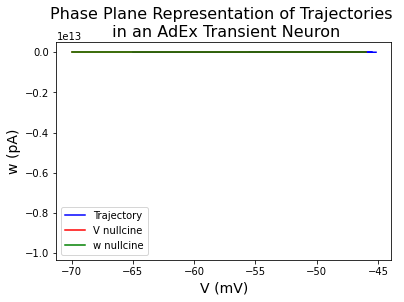

In [62]:

vnull_ws = []
wnull_ws = []
vnull = np.arange(-70,-45,1)
for V in np.arange(-70,-45,1):
    vnull_w = -g_L * (V - E_L) + g_L * slope_f * np.exp((V - V_T)/slope_f) + I
    wnull_w = a*(V - E_L)
    vnull_ws.append(vnull_w)
    wnull_ws.append(wnull_w)
    
idxs = [0]

for idx,v in enumerate(vs_to_plot):
    if v == V_reset: 
        idxs.append(idx)
split_vs = []
split_ws = []
for idx,val in enumerate(idxs):
    if idx < len(idxs)-1:
        split_vs.append(vs_to_plot[val:idxs[idx+1]])
        split_ws.append(ws[val:idxs[idx+1]])
    else:
        split_vs.append(vs_to_plot[val:])
        split_ws.append(ws[val:])
        

for idx,(traj_v,traj_w) in enumerate(zip(split_vs,split_ws)):
    if idx == 0:
        plt.plot(traj_v,traj_w,color='b',label='Trajectory')
    else:
        plt.plot(traj_v,traj_w,color='b')
plt.plot(vnull, vnull_ws,color='r',label='V nullcline')
plt.plot(vnull, wnull_ws,color='g',label='w nullcline')
plt.title('Phase Plane Representation of Trajectories \n in an AdEx Transient Neuron', fontsize='16')
plt.xlabel('V (mV)',fontsize='14')
plt.ylabel('w (pA)',fontsize='14')
plt.legend()